In [8]:
import pccmnn as pc
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

csf_dict = pc.load_csf_data()

keys_to_delete = []

for key in csf_dict:
    sample = csf_dict[key]
    sample = sample[:, :3]
    sample = sample[~np.isnan(sample).any(axis=1)]
    csf_dict[key] = sample
    
    if sample.shape[0] < 2:
        keys_to_delete.append(key)

for key in keys_to_delete:
    del csf_dict[key]

print('number of valid samples:', len(csf_dict))

ab_dict = pc.load_ab_dict('ab_dict.xlsx', 'ABETA')

hid_dim = 32
class ODEModel(nn.Module):
    def __init__(self):
        super(ODEModel, self).__init__()
        self.fc1 = nn.Linear(2, hid_dim)
        self.fc2 = nn.Linear(hid_dim, hid_dim)
        self.fc3 = nn.Linear(hid_dim, hid_dim)
        self.fc4 = nn.Linear(hid_dim, 1)
        self.elu = nn.ELU()

    def forward(self, x):
        x = self.elu(self.fc1(x))
        x = self.elu(self.fc2(x))
        x = self.elu(self.fc3(x))
        x = self.fc4(x)
        return x

class LinearTransform(nn.Module):
    def __init__(self, a, b):
        super(LinearTransform, self).__init__()
        self.a = nn.Parameter(torch.tensor(a, dtype=torch.float64, requires_grad=True))
        self.b = nn.Parameter(torch.tensor(b, dtype=torch.float64, requires_grad=True))

    def forward(self, t):
        s = self.a * t + self.b
        return s


number of valid samples: 325


In [9]:
model = ODEModel()

import torch.nn.init as init
for layer in model.modules():
    if isinstance(layer, nn.Linear):
        init.kaiming_normal_(layer.weight, mode='fan_in', nonlinearity='relu')
        init.zeros_(layer.bias)

model = model.to(torch.float64)
initial_lr = 0.01
optimizer = optim.Adam(model.parameters(), lr=initial_lr)
loss_fn = nn.MSELoss()
loss_curve = []

from tqdm import tqdm
best_loss = 114514
best_loss_curve = []

ab_curve = []
for epoch in tqdm(range(200), desc="Training Progress", unit="epoch"):
    optimizer.zero_grad()
    num = len(csf_dict)
    loss = torch.tensor(0, dtype=torch.float64, requires_grad=True)
    ab_ave_loss = torch.tensor(0, dtype=torch.float64, requires_grad=False)
    for key in csf_dict:
        sample = csf_dict[key]
        a = ab_dict[key][0]
        b = ab_dict[key][1]
        
        # 为当前 key 创建 LinearTransform 实例
        t2s = LinearTransform(a, b)
        
        # 为当前 key 的 LinearTransform 参数创建优化器
        optimizer_ab = optim.Adam(t2s.parameters(), lr=initial_lr)
        
        t = torch.tensor(sample[:,0], dtype=torch.float64)
        s = t2s(t)
        ab_loss = torch.sum(torch.clamp(s, min=-10, max=20) != s)
        ab_ave_loss += ab_loss
        
        abeta = torch.tensor(sample[:,1], dtype=torch.float64)
        tau = torch.tensor(sample[:,2], dtype=torch.float64)
        tau_pred = pc.predict(model, s, tau[0], abeta)
        sample_loss = loss_fn(tau_pred, tau)
        loss = loss + sample_loss
        
        ab_ave_loss += ab_loss
        ab_loss = ab_loss + 1e2 * sample_loss
        ab_loss.backward(retain_graph=True)
        optimizer_ab.step()
        optimizer_ab.zero_grad()
        
        ab_dict[key][0] = t2s.a.item()
        ab_dict[key][1] = t2s.b.item()

    loss = loss / num
    ab_ave_loss = ab_ave_loss / num
    ab_curve.append(ab_ave_loss)

    if loss.item() < best_loss:
        best_model = copy.deepcopy(model)
        best_loss = loss.item()

    best_loss_curve.append(best_loss)
    loss_curve.append(loss.item())

    loss.backward(retain_graph=True)
    optimizer.step()

torch.save(best_model, 'model_tau.pt')
pc.save_ab_dict_to_xlsx(ab_dict, 'ab_dict.xlsx', "TAU")

Training Progress: 100%|██████████| 200/200 [02:22<00:00,  1.41epoch/s]

ab_dict 已保存到 ab_dict.xlsx 的 TAU sheet 中（已清空旧数据）


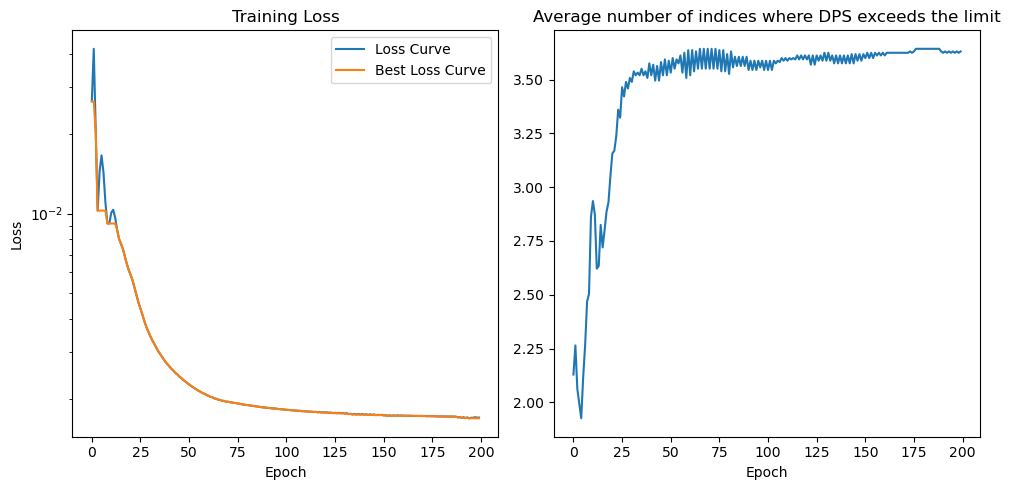

In [10]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 创建2行3列的子图
axes = axes.flatten()  # 将axes转换为1D数组，方便索引
ax = axes[0]
ax.plot(loss_curve, label='Loss Curve')
ax.plot(best_loss_curve, label='Best Loss Curve')
ax.set_yscale('log')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss')
ax.legend()
ax = axes[1]
ax.plot(ab_curve, label='ab Loss')
ax.set_xlabel('Epoch')
ax.set_title('Average number of indices where DPS exceeds the limit')
plt.tight_layout()  # 调整子图布局，避免重叠
plt.show()  # 显示图像

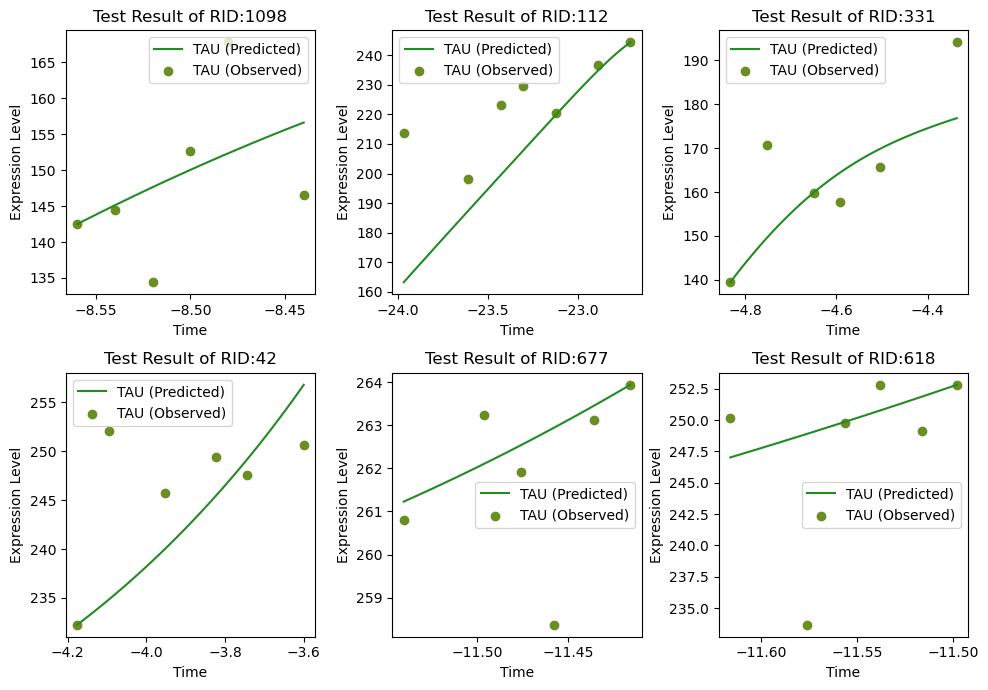

In [19]:
import torch
import torch.nn as nn
import numpy as np
import pccmnn as pc
model_abeta = torch.load('model_abeta.pt')
model = torch.load('model_tau.pt')
ab_dict_tau = pc.load_ab_dict('ab_dict.xlsx', 'TAU') # 由于预测tau需要用到相同时间列的abeta预测值，因此必须同时使用相同的a,b进行线性变换
keys = pc.sampling(csf_dict, 6, 6)  # 获取6个不同的key
fig, axes = plt.subplots(2, 3, figsize=(10, 7))  # 创建2行3列的子图
axes = axes.flatten()  # 将axes转换为1D数组，方便索引

for i, key in enumerate(keys):
    sample = csf_dict[key]
    a, b = ab_dict[key][0], ab_dict[key][1]
    t = sample[:, 0]
    s = a * t + b
    s_pred = np.linspace(s[0], s[-1], 100)
    
    abeta0 = torch.tensor(sample[0, 1])
    abeta_pred = pc.predict(model_abeta, s_pred, abeta0).cpu().detach().numpy()
    
    tau0 = torch.tensor(sample[0, 2])
    tau = sample[:, 2]
    tau_pred = pc.predict(model, s_pred, tau0, abeta_pred).cpu().detach().numpy()
    
    tau_pred = pc.re_nor(tau_pred, 0)
    tau = pc.re_nor(tau, 0)
    
    # 选择当前的子图
    ax = axes[i]
    ax.plot(s_pred, tau_pred, label='TAU (Predicted)', color="#228B22")
    ax.scatter(s, tau, color="#6B8E23", marker='o', label='TAU (Observed)')
    ax.set_xlabel('Time')
    ax.set_ylabel('Expression Level')
    ax.set_title(f'Test Result of RID:{key}')
    ax.legend()

plt.tight_layout()  # 调整子图布局，避免重叠
plt.show()  # 显示图像

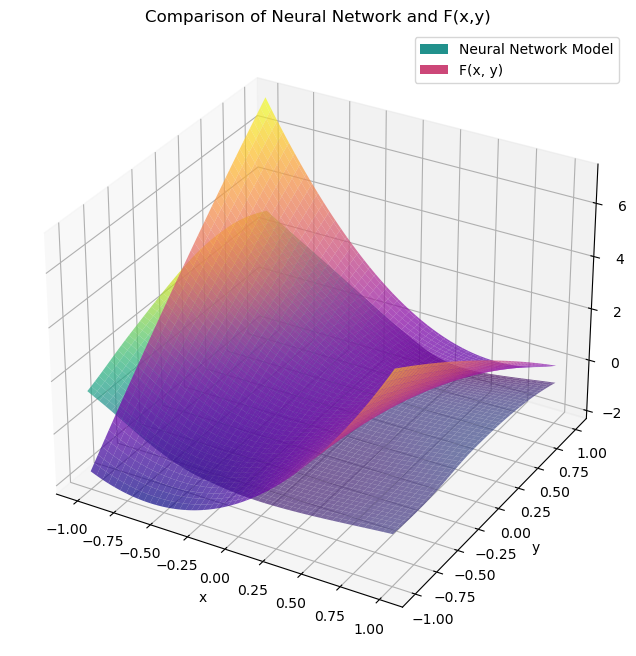

In [12]:
from mpl_toolkits.mplot3d import Axes3D

def F(x,y):
    return 0.788*y-0.246*y**2+0.002*x+3.066*x**2-3.65*x*y

grid_size = 100
x_vals = torch.tensor(np.linspace(-1, 1, grid_size))
y_vals = torch.tensor(np.linspace(-1, 1, grid_size))

X, Y = np.meshgrid(x_vals.numpy(), y_vals.numpy())
input = torch.tensor(np.stack((X.flatten(), Y.flatten()), axis=0).T, dtype=torch.float64)
dx = model(input).detach().numpy().reshape(grid_size, grid_size)
f = F(X, Y)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Use plot_surface with explicit colors and labels
surface_dx = ax.plot_surface(X, Y, dx, cmap='viridis', alpha=0.7, label='Neural Network Model')
surface_f = ax.plot_surface(X, Y, f, cmap='plasma', alpha=0.7, label='F(x, y)')

# Manually create proxy artists for the legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=surface_dx.cmap(0.5), label='Neural Network Model'),
                   Patch(facecolor=surface_f.cmap(0.5), label='F(x, y)')]
ax.legend(handles=legend_elements)  # Correct way to add a legend

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
plt.title("Comparison of Neural Network and F(x,y)")
plt.show()